In [2]:
!pip install langchain --quiet
!pip install langchain_community --quiet
!pip install --upgrade --quiet langgraph
!pip install langchain_mistralai --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.5/118.5 kB 10.2 MB/s eta 0:00:00


In [7]:
from google.colab import userdata
from langchain_mistralai import ChatMistralAI
api_key=userdata.get('MISTRAL_AI_API_KEY')
llm=ChatMistralAI(api_key=api_key)

In [8]:
import pandas as pd
from langchain_community.utilities import SQLDatabase
from sqlalchemy import create_engine

df=pd.read_csv("/content/sample_data/Retail and wherehouse Sale.csv")

engine=create_engine("sqlite:///retail_warehouse_sales.db")
df.to_sql(con=engine,if_exists="replace",name="retail_warehouse_sales",index=False)

db=SQLDatabase(engine=engine)

In [10]:
df.head(5)

,YEAR,MONTH,SUPPLIER,ITEM CODE,ITEM DESCRIPTION,ITEM TYPE,RETAIL SALES,RETAIL TRANSFERS,WAREHOUSE SALES
0,2020,1,REPUBLIC NATIONAL DISTRIBUTING CO,100009,BOOTLEG RED - 750ML,WINE,0.00,0.0,2.0
1,2020,1,PWSWN INC,100024,MOMENT DE PLAISIR - 750ML,WINE,0.00,1.0,4.0
2,2020,1,RELIABLE CHURCHILL LLLP,1001,S SMITH ORGANIC PEAR CIDER - 18.7OZ,BEER,0.00,0.0,1.0
3,2020,1,LANTERNA DISTRIBUTORS INC,100145,SCHLINK HAUS KABINETT - 750ML,WINE,0.00,0.0,1.0
4,2020,1,DIONYSOS IMPORTS INC,100293,SANTORINI GAVALA WHITE - 750ML,WINE,0.82,0.0,0.0


In [9]:
db.run("select * from retail_warehouse_sales limit 5;")

"[(2020, 1, 'REPUBLIC NATIONAL DISTRIBUTING CO', '100009', 'BOOTLEG RED - 750ML', 'WINE', 0.0, 0.0, 2.0), (2020, 1, 'PWSWN INC', '100024', 'MOMENT DE PLAISIR - 750ML', 'WINE', 0.0, 1.0, 4.0), (2020, 1, 'RELIABLE CHURCHILL LLLP', '1001', 'S SMITH ORGANIC PEAR CIDER - 18.7OZ', 'BEER', 0.0, 0.0, 1.0), (2020, 1, 'LANTERNA DISTRIBUTORS INC', '100145', 'SCHLINK HAUS KABINETT - 750ML', 'WINE', 0.0, 0.0, 1.0), (2020, 1, 'DIONYSOS IMPORTS INC', '100293', 'SANTORINI GAVALA WHITE - 750ML', 'WINE', 0.82, 0.0, 0.0)]"

In [11]:
from langchain.chains import create_sql_query_chain
from langchain.prompts import PromptTemplate
from langchain.tools.sql_database.tool import QuerySQLDataBaseTool

create_query_prompt=PromptTemplate(
    input_variables=["table_info","question","top_k"],
    template="""You are an agent designed to interact with a SQL database.
    Your job is to create only the sql query based on the user question.
    Do not produce any other outputs than the correct sql query.
    The query must not contain "\". The query should be clean and executable

    question: {input}
    table_info: {table_info}
    top_k: {top_k}
    query:
    """
)

create_query_chain=create_sql_query_chain(llm=llm,db=db,prompt=create_query_prompt)
execute_query_chain=QuerySQLDataBaseTool(db=db)

In [12]:
demo_chain=create_query_chain | execute_query_chain

In [13]:
demo_chain.invoke({"question":"What is the summary of the data?"})

"[(2020, 1, None, '107', 'JIGGER MEASURE SHOT GLASS', 'STR_SUPPLIES', 14.69, 18.0, 0.0), (2020, 1, None, '113', 'BARTENDERS BLACK  BOOK', 'STR_SUPPLIES', 0.4, 0.0, 0.0), (2020, 1, None, '115', 'PLASTIC SHOT GLASS PACK', 'STR_SUPPLIES', 5.71, 6.0, 0.0), (2020, 1, None, '117', 'WHISKEY TASTING JOURNAL', 'STR_SUPPLIES', 0.08, 0.0, 0.0), (2020, 1, None, '118', 'PLASTIC WINE GLASS PACK', 'STR_SUPPLIES', 7.4, 10.0, 0.0)]"

In [35]:
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser,BaseOutputParser


error_re_write_message="""You an SQL query re-writter that resolves the error in
                                the current sql query executed based on the error
                                output received.Do not produce any other
                                outputs than the correct sql query.
                                The query must not contain "\".
                                The query should be clean and executable in sqlite.
                                Only create the modified SQL query as your output."""

error_re_write_prompt=ChatPromptTemplate.from_messages(
    [
        ("system",error_re_write_message),
        ("human","Here is the error output:{output}, Formulate an error free SQL query")
    ]
)

re_write_chain=error_re_write_prompt | llm | StrOutputParser()


answer_prompt=PromptTemplate.from_template(
            """
        Given the following user question, corresponding SQL query, and SQL result, answer the user question.

Question: {question}
SQLQuery: {query}
SQL Result: {output}
Answer: """
)

answer_chain= answer_prompt | llm | StrOutputParser()



In [24]:
class ErrorGradeParser(BaseOutputParser):

  @property
  def _type(self)->str:
    return "error_grade_parser"

  def parse(self,text:str)->str:
        text=text.strip().lower()
        if text.startswith("yes"):
          return "yes"

        else:
          return "no"

error_grade_parser=ErrorGradeParser()

error_prompt_message="""You are an error grader assessing whether the received sql query output has an error \n
     Give a binary score 'yes' or 'no'. Yes' means that the output is an error ouput.
     Give yes or no,nothing else. No explanations as well. A plain yes or no"""

error_prompt=ChatPromptTemplate.from_messages([
    ('system',error_prompt_message),
    ('human',"Here is the query output: {output}")
])

error_grade_chain=error_prompt | llm | error_grade_parser

In [15]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph

class GraphState(TypedDict):
  query:str
  output:str
  question:str
  answer:str



In [36]:
import time
def create_query(state:GraphState):
  print("--CREATE QUERY--")
  question=state["question"]
  query=create_query_chain.invoke({"question":question})
  print(f"QUERY = {query}")
  time.sleep(3)
  return {
      "query":query,
      "question":question
      }

def execute_query(state:GraphState):
  print("--EXECUTE QUERY--")
  question=state["question"]
  query=state["query"]
  output=execute_query_chain.invoke({"query":query})
  print(f"OUTPUT = {output}")
  time.sleep(3)
  return {
      "output":output,
      "query":query,
      "question":question
      }

def generate(state:GraphState):
  print("--GENERATE--")
  question=state["question"]
  query=state["query"]
  output=state["output"]
  time.sleep(3)
  answer=answer_chain.invoke({"question":question,"query":query,"output":output})
  print(f"ANSWER = {answer}")
  time.sleep(3)
  return{
      "answer":answer,
      "question":question,
      "query":query,
      "output":output
      }

def error_re_write(state:GraphState):
  print("--RE-WRITE--")
  question=state["question"]
  query=state["query"]
  output=state["output"]
  query=re_write_chain.invoke({"output":output})
  print(f"RE-WRTITTEN QUERY: {query} ")
  return{
      "query":query,
      "question":question
  }

def grade_error(state:GraphState):
  print("--GRADE ERROR--")
  question=state["question"]
  query=state["query"]
  output=state["output"]
  grade=error_grade_chain.invoke({"output":output})
  print(f"Error = {grade}")
  return{
      "grade":grade,
      "question":question,
      "query":query,
      "output":output
  }

def decide_generate(state:GraphState):
  print("--DECIDE GENERATE--")
  grade=state["grade"]
  if grade=="yes":
    return "error_re_write"
  else:
    return "generate"

In [37]:
from langgraph.graph import StateGraph,START,END

workflow=StateGraph(GraphState)

workflow.add_node("create_query",create_query)
workflow.add_node("execute_query",execute_query)
workflow.add_node("generate",generate)
workflow.add_node("error_re_write",error_re_write)
workflow.add_node("grade_error",grade_error)



workflow.add_edge(START,"create_query")
workflow.add_edge("create_query","execute_query")
workflow.add_edge("execute_query","grade_error")
workflow.add_conditional_edges(
    "grade_error",
    decide_generate,
    {
        "error_re_write":"error_re_write",
        "generate":"generate",
    }
        )
workflow.add_edge("error_re_write","execute_query")
workflow.add_edge("generate",END)

In [38]:
app=workflow.compile()

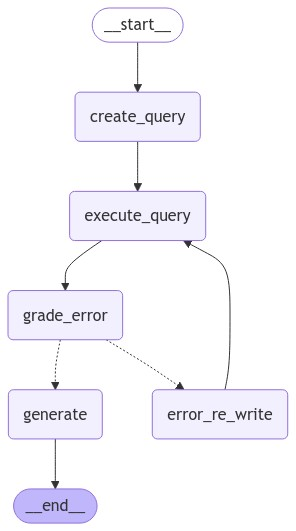

In [39]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))


In [41]:

from pprint import pprint

# Run
inputs = {
    "question": "What is the summary of the dataset?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["answer"])

--CREATE QUERY--
QUERY = SELECT
    "YEAR",
    "MONTH",
    "SUPPLIER",
    "ITEM CODE",
    "ITEM DESCRIPTION",
    "ITEM TYPE",
    SUM("RETAIL SALES") AS "TOTAL RETAIL SALES",
    SUM("RETAIL TRANSFERS") AS "TOTAL RETAIL TRANSFERS",
    SUM("WAREHOUSE SALES") AS "TOTAL WAREHOUSE SALES"
FROM
    retail_warehouse_sales
GROUP BY
    "YEAR",
    "MONTH",
    "SUPPLIER",
    "ITEM CODE",
    "ITEM DESCRIPTION",
    "ITEM TYPE"
LIMIT 5;
"Node 'create_query':"
'\n---\n'
--EXECUTE QUERY--
OUTPUT = [(2020, 1, None, '107', 'JIGGER MEASURE SHOT GLASS', 'STR_SUPPLIES', 14.69, 18.0, 0.0), (2020, 1, None, '113', 'BARTENDERS BLACK  BOOK', 'STR_SUPPLIES', 0.4, 0.0, 0.0), (2020, 1, None, '115', 'PLASTIC SHOT GLASS PACK', 'STR_SUPPLIES', 5.71, 6.0, 0.0), (2020, 1, None, '117', 'WHISKEY TASTING JOURNAL', 'STR_SUPPLIES', 0.08, 0.0, 0.0), (2020, 1, None, '118', 'PLASTIC WINE GLASS PACK', 'STR_SUPPLIES', 7.4, 10.0, 0.0)]
"Node 'execute_query':"
'\n---\n'
--GRADE ERROR--
Error = no
--DECIDE GENERATE--
"N